## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from tensorflow.keras.callbacks import EarlyStopping
from seq_diff import diff_html

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/ncbi_03/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    token_index = data['token_index'].tolist()

In [4]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(token_index)

(25865, 3813, 4)
(25865, 3813, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [5]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [6]:
X_data = encoder_input_data[:1000]
Y_data = decoder_input_data[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (1000, 3813, 4)
Y_data (1000, 3813, 4)


## Inference

In [7]:
model = keras.models.load_model("data/ncbi_03/model_gru_32_41")
model

2022-04-06 13:54:48.862055: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-04-06 13:54:48.862079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mif325-gpu2
2022-04-06 13:54:48.862085: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mif325-gpu2
2022-04-06 13:54:48.862131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.54.0
2022-04-06 13:54:48.862149: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-04-06 13:54:48.862153: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.47.3 does not match DSO version 510.54.0 -- cannot find working devices in this configuration
2022-04-06 13:54:48.862396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This Tens

In [8]:
i = 5
x1 = decode_seq(X_data[i:i+1,:,:])[0]
y1 = decode_seq(Y_data[i:i+1,:,:])[0]

_ = diff_html(x1, y1, display_a=True, display_b=True)

In [9]:
yp1 = decode_seq(model.predict([ X_data[i:i+1,:,:], np.array([0.01])]))[0]

_ = diff_html(y1, yp1, display_a=True, display_b=True)

# Random rate search

In [10]:
ce_0 = 0.007816102

In [11]:
rand_rates = []
for r in tqdm(np.arange(0, 0.21, 0.01)):
    Y_pred = model.predict([X_data, np.full((len(X_data)), r)])
    cc = keras.losses.CategoricalCrossentropy()(X_data, Y_pred).numpy()
    rand_rates.append([r, cc])
rand_rates = np.array(rand_rates)

  0%|          | 0/21 [00:00<?, ?it/s]

In [12]:
from scipy.optimize import curve_fit
func = lambda t, a, b, c, d: a * t * t * t + b * t * t + c * t + d
p, _ = curve_fit(func, rand_rates[:,0],  rand_rates[:,1])

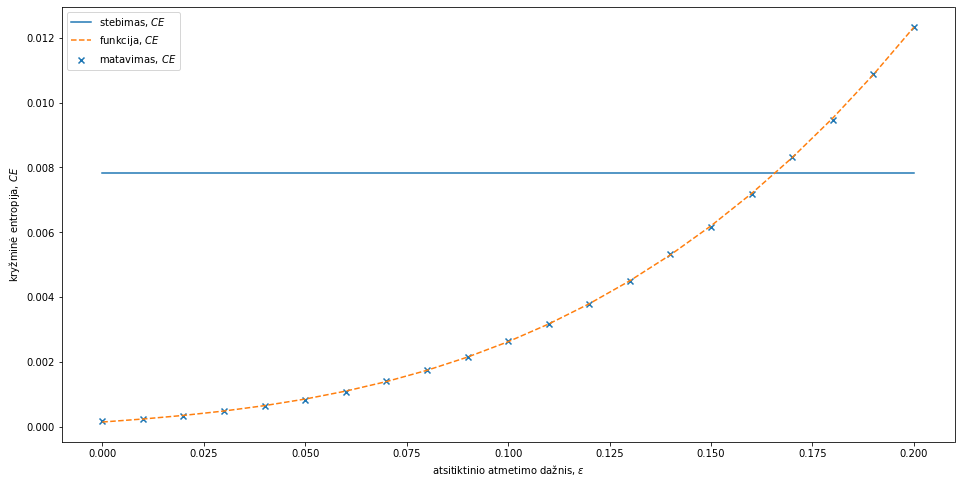

In [13]:
plt.plot(rand_rates[:,0], np.full_like(rand_rates[:,1], ce_0), label="stebimas, $CE$")
plt.plot(rand_rates[:,0], func(rand_rates[:,0], p[0], p[1], p[2], p[3]), '--', label="funkcija, $CE$")
plt.scatter(rand_rates[:,0], rand_rates[:,1], marker='x', label="matavimas, $CE$")
plt.ylabel('kryžminė entropija, $CE$')
plt.xlabel('atsitiktinio atmetimo dažnis, $ε$')

plt.legend()
plt.show()

In [14]:
p, _ = curve_fit(func, rand_rates[:,1],  rand_rates[:,0])
epsilon = func(ce_0, p[0], p[1], p[2], p[3])
print([f'{j:0.5f}' for i,j in enumerate(p)])
epsilon

['205327.18024', '-5051.27439', '47.11029', '0.00678']


0.16445493768357486

$\epsilon=202822.91062\epsilon_0^3-5014.94669\epsilon_0^2+46.95614\epsilon_0+0.00703$

# Metrics

In [15]:
Y_pred = model.predict([X_data, np.full((len(X_data)), epsilon)])
Y_pred.shape

(1000, 3813, 4)

In [16]:
keras.losses.CategoricalCrossentropy()(X_data, Y_data).numpy()

0.007816102

In [17]:
keras.losses.CategoricalCrossentropy()(X_data, Y_pred).numpy()

0.007661949

In [18]:
keras.losses.CategoricalCrossentropy()(Y_data, Y_pred).numpy()

0.012616713

# X vs Y true vs Y pred

In [22]:
cce = []
for i in tqdm(range(len(X_data))):
    cce.append([
        keras.losses.CategoricalCrossentropy()(X_data[i:i + 1], Y_data[i:i + 1]).numpy(),
        keras.losses.CategoricalCrossentropy()(X_data[i:i + 1], Y_pred[i:i + 1]).numpy(),
        keras.losses.CategoricalCrossentropy()(Y_data[i:i + 1], Y_pred[i:i + 1]).numpy()
    ])
cce = np.array(cce)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
plot_names = [
    "X seka - Y stebima seka",
    "X seka - Y sugeneruota seka",
    "Y stebima seka - Y sugeneruota seka"
]

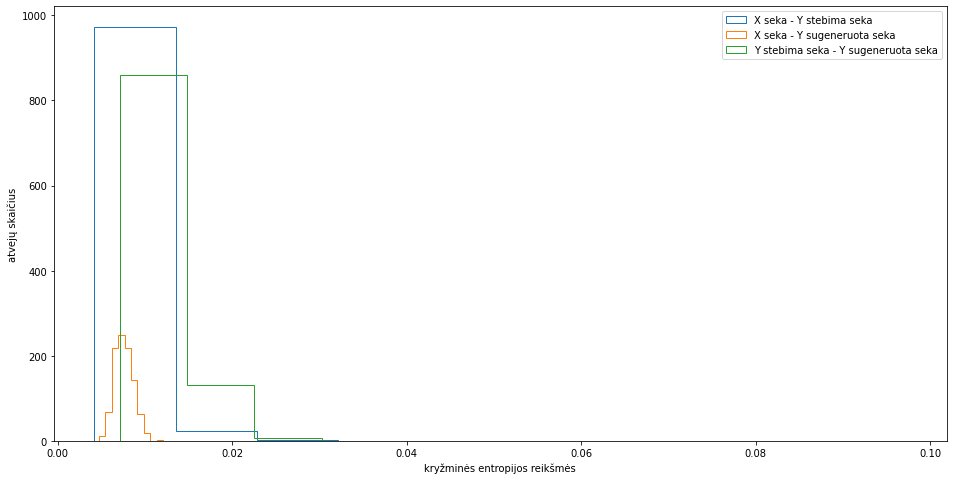

In [24]:
for i, n in enumerate(plot_names):
    plt.hist(cce[:,i], fill=False, bins = 10, histtype='step', label=n)
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [25]:
X_secs = decode_seq(X_data)
Y_secs = decode_seq(Y_data)
Y_pred_secs = decode_seq(Y_pred)

In [26]:
lev_distances = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    lev_distances.append([ 
        distance(x,y), distance(x,p), distance(y,p)
    ])
lev_distances = np.array(lev_distances)

  0%|          | 0/1000 [00:00<?, ?it/s]

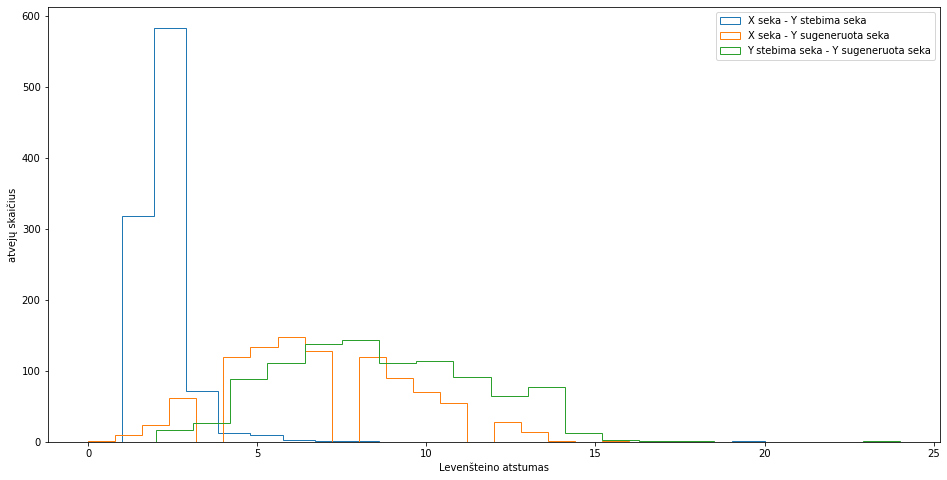

In [27]:
for i, n in enumerate(plot_names):
    plt.hist(lev_distances[:,i], fill=False, bins = 20, density=False, histtype='step', label=n)
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [28]:
lev_ratio = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    lev_ratio.append([ 
        ratio(x,y), ratio(x,p), ratio(y,p)
    ])
lev_ratio = np.array(lev_ratio)

  0%|          | 0/1000 [00:00<?, ?it/s]

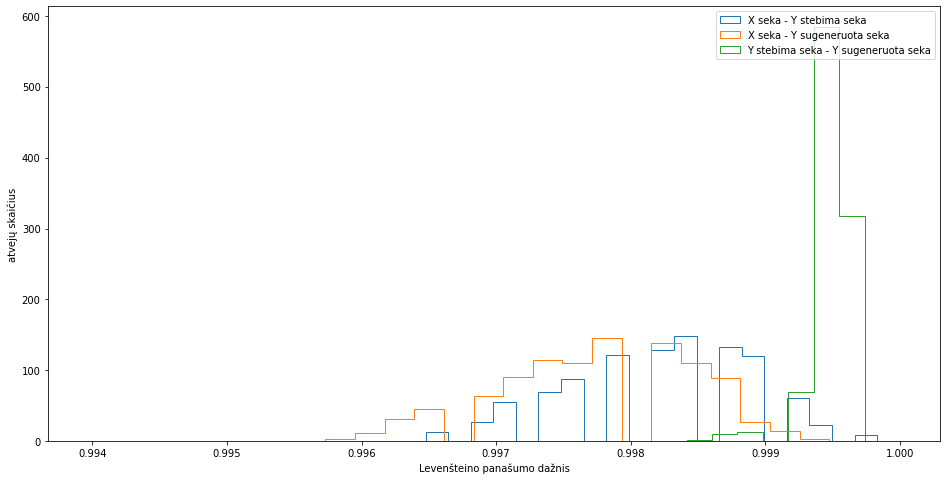

In [29]:
plt.hist(lev_ratio[:,1], fill=False, bins = 25, histtype='step', label="X seka - Y stebima seka")
plt.hist(lev_ratio[:,2], fill=False, bins = 25, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(lev_ratio[:,0], fill=False, bins = 25, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [30]:
ham_distances = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    ham_distances.append([ 
        hamming(x,y), hamming(x,p), hamming(y,p)
    ])
ham_distances = np.array(ham_distances)

  0%|          | 0/1000 [00:00<?, ?it/s]

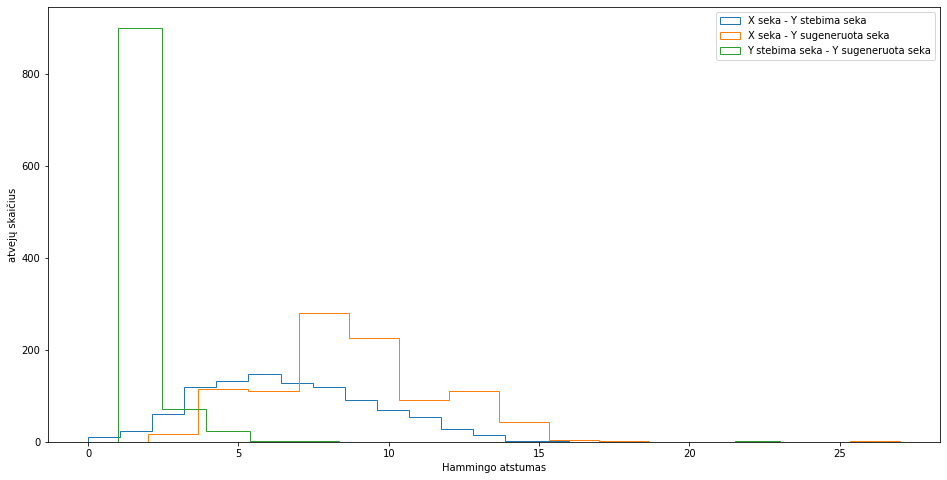

In [31]:
plt.hist(ham_distances[:,1], fill=False, bins = 15, histtype='step', label="X seka - Y stebima seka")
plt.hist(ham_distances[:,2], fill=False, bins = 15, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(ham_distances[:,0], fill=False, bins = 15, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('Hammingo atstumas')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

# Mutacijos

In [37]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [38]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_pred, axis = 2)
    ) != 0.0).astype(int), axis = 0)

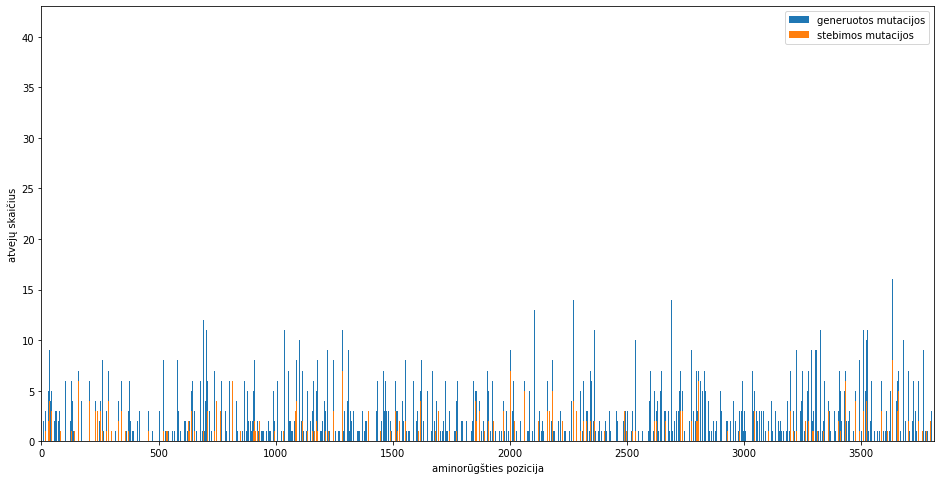

In [60]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut01))
plt.xlabel('aminorūgšties pozicija')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

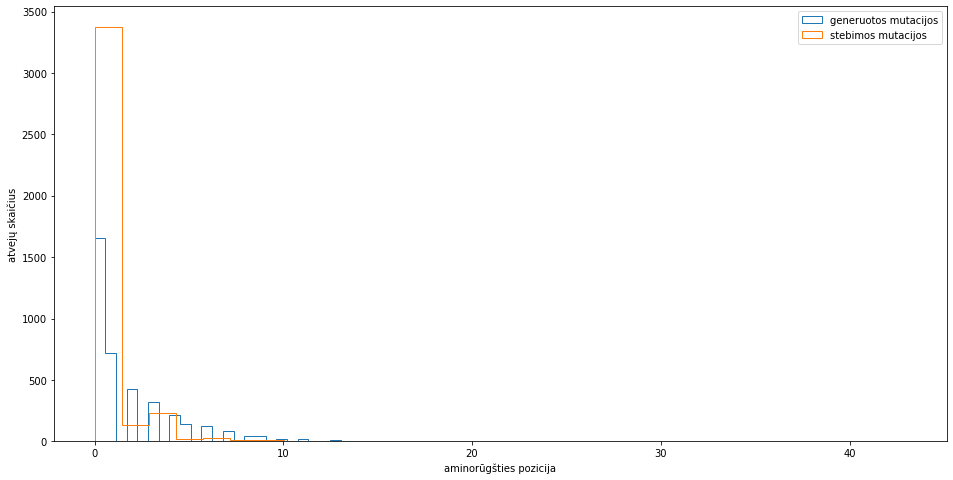

In [59]:
plt.hist(mut02, bins = 30, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 30, label = 'stebimos mutacijos', fill = False, histtype='step')

plt.legend()
plt.show()

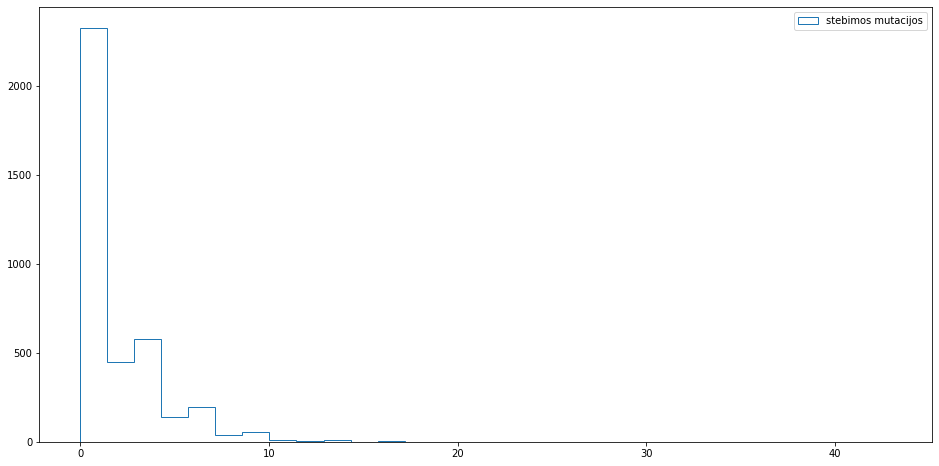

In [41]:
plt.hist(abs(mut02 - mut01), bins = 30, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()

# Siblings

In [42]:
Y_pred_sibs = []
for i in tqdm(range(10)):
    y_ = model.predict([ X_data, np.full((len(X_data)), epsilon)])
    Y_pred_sibs.append([])
    for j in range(len(y_)):
        Y_pred_sibs[i].append(
            keras.losses.CategoricalCrossentropy()(X_data[j:j + 1], y_[j:j + 1]).numpy()
        )
Y_pred_sibs = np.array(Y_pred_sibs)

  0%|          | 0/10 [00:00<?, ?it/s]

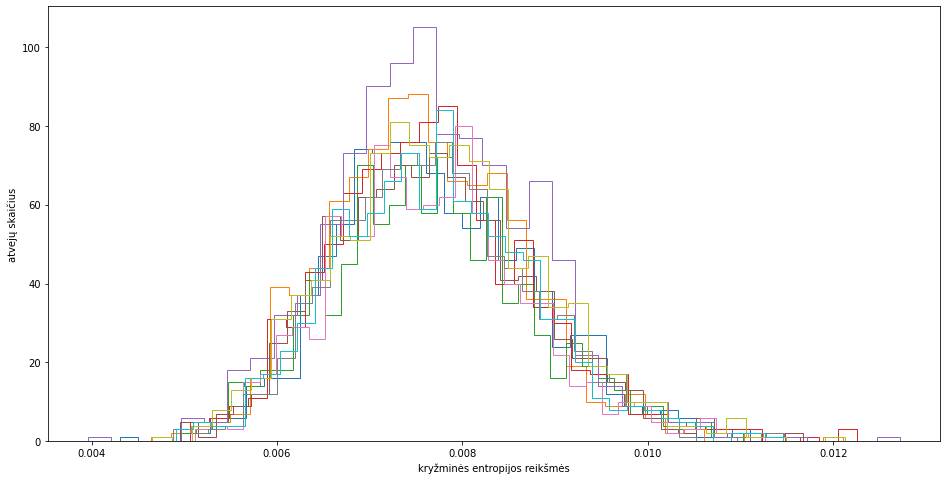

In [43]:
for i in range(len(Y_pred_sibs)):
    plt.hist(Y_pred_sibs[i], fill=False, bins = 35, histtype='step')
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()

In [44]:
i = 2
n = 100

In [45]:
Y_pred_sibs = []
for i in tqdm(range(n)):
    y_ = model.predict([ X_data[i:i+1], np.full((1), epsilon)])
    Y_pred_sibs.append(y_[0])
Y_pred_sibs = np.array(Y_pred_sibs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [46]:
mut03 = np.sum(
    (np.subtract(
        np.repeat(np.argmax(X_data[i:i+1], axis = 2), n, axis=0), 
        np.argmax(Y_pred_sibs, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [47]:
mut04 = np.sum(
    (np.subtract(
        np.argmax(X_data[i:i+1], axis = 2), 
        np.argmax(Y_data[i:i+1], axis = 2)
    ) != 0.0).astype(int), axis = 0)

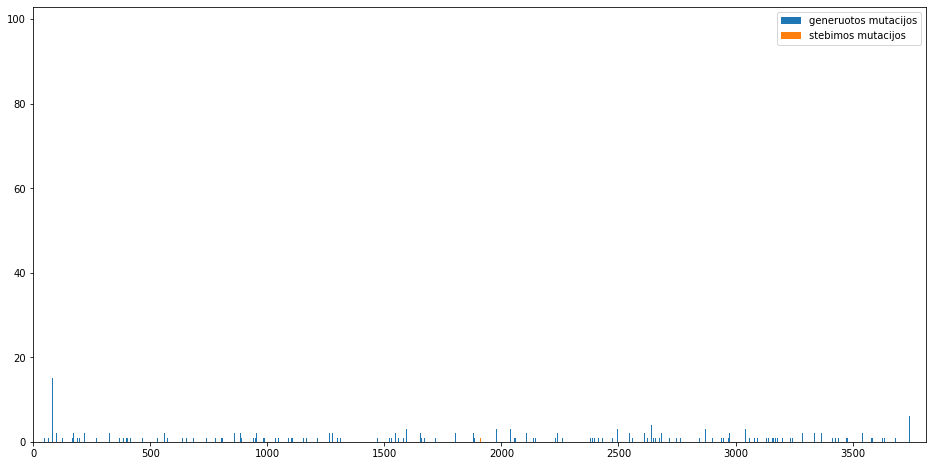

In [48]:
x_range = list(range(len(mut03)))
plt.bar(x_range, mut03, bottom=mut04, label = 'generuotos mutacijos')
plt.bar(x_range, mut04, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut03))
plt.legend()
plt.show()

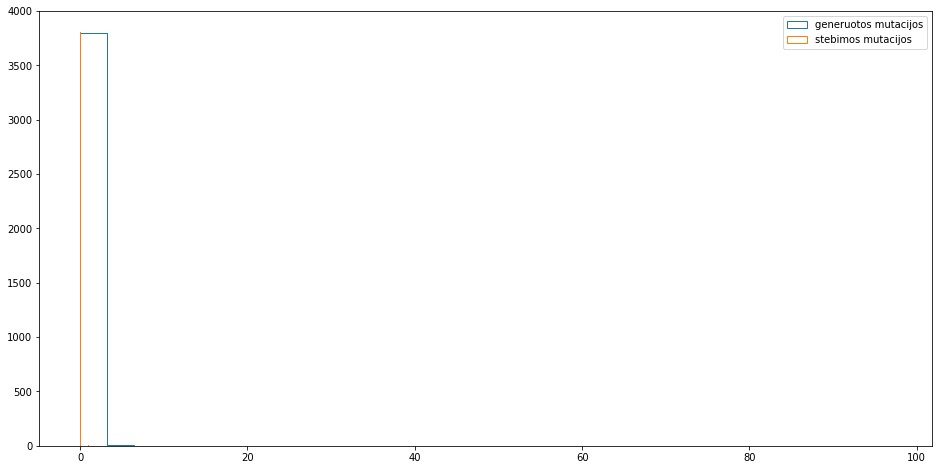

In [49]:
plt.hist(mut03, bins = 30, label = 'generuotos mutacijos', fill = False, histtype='step')
_ = plt.hist(mut04, bins = 30, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()

In [50]:
i = 5
x1 = decode_seq(X_data[i:i+1,:,:])[0]
y1 = decode_seq(Y_data[i:i+1,:,:])[0]

_ = diff_html(x1, y1, display_a=True, display_b=True)

In [57]:
yp1 = decode_seq(model.predict([ X_data[i:i+1,:,:], np.array([epsilon / 1.25])]))[0]

_ = diff_html(x1, yp1, display_a=True, display_b=True)

# Iterations and randomness

In [96]:
Y_pred_iter = X_data
mut05 = None
dists = [ keras.losses.CategoricalCrossentropy()(X_data, Y_pred_iter).numpy() ]

for _ in tqdm(range(500)):
    Y_pred_iter_next = model.predict([Y_pred_iter, np.full((len(X_data)), epsilon / 1.4)])
    
    mut05_next = np.sum(
        (np.subtract(
            np.argmax(Y_pred_iter_next, axis = 2), 
            np.argmax(Y_pred_iter, axis = 2)
        ) != 0.0).astype(int), axis = 0)
    mut05 = mut05_next if mut05 is None else mut05_next + mut05
    Y_pred_iter = Y_pred_iter_next
    
    dists.append(keras.losses.CategoricalCrossentropy()(X_data, Y_pred_iter).numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

In [106]:
import numpy as np

LEV_VALUES = np.array([0, 1, 2, 3, 4, 5, 6, 7, 9])
LEV_PROBS  = np.array([1.07600733e-02, 3.15934066e-01, 5.84478022e-01, 7.09706960e-02, 
                       1.05311355e-02, 5.72344322e-03, 1.14468864e-03, 2.28937729e-04, 2.28937729e-04])

FREQ_VALUES = np.array([4, 5, 6, 7, 8, 12, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 37, 40, 41, 43, 45, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 88, 89, 92, 93, 95, 96, 97, 98, 99, 100, 101, 103, 105, 110, 112, 113, 116, 119, 121, 122, 125, 128, 133, 134, 135, 138, 140, 141, 144, 147, 148, 151, 154, 155, 158, 161, 164, 167, 173, 175, 179, 182, 183, 185, 189, 190, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 226, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 242, 244, 245, 246, 248, 249, 251, 253, 256, 258, 259, 260, 261, 262, 263, 266, 267, 275, 276, 279, 280, 281, 282, 283, 285, 286, 287, 288, 289, 290, 292, 295, 296, 303, 304, 305, 312, 317, 320, 323, 324, 327, 330, 334, 335, 337, 338, 341, 344, 347, 348, 351, 353, 354, 357, 360, 362, 365, 367, 368, 370, 377, 378, 381, 388, 389, 395, 400, 404, 405, 406, 407, 410, 411, 412, 414, 415, 416, 419, 420, 422, 423, 424, 425, 426, 428, 429, 430, 431, 432, 434, 435, 436, 437, 440, 441, 442, 443, 444, 446, 450, 451, 453, 454, 455, 456, 457, 458, 460, 462, 463, 465, 467, 468, 469, 470, 471, 473, 475, 482, 484, 485, 486, 487, 488, 491, 492, 503, 506, 510, 512, 514, 515, 516, 517, 518, 519, 521, 523, 525, 526, 528, 529, 530, 531, 532, 533, 536, 537, 538, 539, 540, 541, 542, 544, 545, 548, 549, 550, 553, 554, 555, 556, 557, 560, 561, 562, 563, 564, 566, 567, 568, 569, 572, 576, 578, 584, 587, 588, 589, 591, 592, 594, 599, 604, 608, 616, 617, 620, 623, 625, 626, 627, 630, 632, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 647, 648, 650, 652, 654, 656, 657, 659, 661, 662, 663, 664, 665, 666, 668, 671, 675, 677, 678, 681, 683, 686, 689, 692, 696, 699, 701, 704, 706, 710, 713, 715, 718, 719, 723, 724, 725, 726, 728, 731, 732, 733, 734, 736, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 750, 751, 752, 754, 755, 756, 757, 760, 762, 763, 764, 765, 766, 767, 768, 769, 771, 772, 773, 775, 777, 778, 779, 780, 781, 783, 784, 786, 787, 788, 789, 790, 793, 798, 800, 806, 810, 811, 812, 813, 814, 815, 817, 818, 820, 821, 822, 825, 828, 840, 842, 845, 850, 851, 854, 856, 859, 860, 861, 862, 863, 864, 866, 867, 868, 869, 872, 873, 875, 878, 881, 884, 887, 889, 890, 892, 893, 894, 895, 896, 898, 901, 905, 906, 908, 910, 911, 912, 914, 915, 917, 919, 920, 921, 923, 924, 928, 929, 935, 938, 939, 940, 941, 943, 944, 947, 950, 953, 957, 959, 961, 962, 965, 967, 968, 969, 971, 980, 981, 983, 986, 987, 992, 1001, 1004, 1007, 1010, 1013, 1014, 1015, 1020, 1025, 1028, 1029, 1030, 1031, 1032, 1034, 1035, 1036, 1041, 1043, 1044, 1046, 1049, 1052, 1054, 1055, 1059, 1061, 1069, 1071, 1075, 1082, 1083, 1085, 1087, 1094, 1098, 1100, 1101, 1103, 1108, 1109, 1112, 1114, 1115, 1117, 1119, 1121, 1124, 1126, 1127, 1130, 1132, 1135, 1136, 1143, 1144, 1145, 1148, 1149, 1150, 1153, 1157, 1163, 1166, 1169, 1172, 1175, 1176, 1178, 1180, 1181, 1182, 1184, 1187, 1196, 1199, 1207, 1208, 1214, 1215, 1218, 1220, 1222, 1223, 1227, 1229, 1230, 1232, 1235, 1236, 1238, 1239, 1240, 1241, 1244, 1249, 1250, 1254, 1262, 1265, 1268, 1274, 1275, 1277, 1278, 1280, 1288, 1289, 1292, 1295, 1298, 1304, 1310, 1316, 1318, 1319, 1320, 1325, 1326, 1328, 1330, 1331, 1334, 1336, 1340, 1349, 1353, 1354, 1355, 1357, 1358, 1359, 1361, 1362, 1364, 1369, 1370, 1373, 1374, 1375, 1376, 1378, 1382, 1383, 1384, 1395, 1400, 1401, 1402, 1403, 1408, 1409, 1410, 1415, 1418, 1421, 1422, 1423, 1424, 1425, 1428, 1429, 1430, 1432, 1434, 1435, 1436, 1441, 1442, 1446, 1447, 1448, 1449, 1450, 1452, 1454, 1457, 1461, 1466, 1467, 1468, 1469, 1472, 1473, 1477, 1479, 1480, 1481, 1490, 1496, 1499, 1500, 1501, 1502, 1506, 1508, 1514, 1517, 1518, 1520, 1521, 1523, 1525, 1526, 1527, 1529, 1532, 1536, 1538, 1541, 1546, 1548, 1550, 1551, 1556, 1557, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1568, 1578, 1580, 1582, 1584, 1586, 1592, 1594, 1595, 1596, 1601, 1607, 1609, 1619, 1622, 1625, 1628, 1632, 1635, 1639, 1640, 1643, 1650, 1653, 1657, 1658, 1659, 1661, 1664, 1667, 1671, 1672, 1673, 1678, 1679, 1680, 1681, 1685, 1692, 1694, 1695, 1697, 1700, 1703, 1704, 1705, 1707, 1708, 1709, 1712, 1713, 1714, 1716, 1717, 1718, 1719, 1721, 1722, 1724, 1725, 1727, 1730, 1733, 1734, 1736, 1739, 1742, 1746, 1748, 1749, 1751, 1752, 1754, 1757, 1760, 1762, 1764, 1766, 1769, 1771, 1773, 1778, 1779, 1782, 1785, 1786, 1791, 1799, 1802, 1806, 1807, 1808, 1810, 1811, 1814, 1817, 1820, 1823, 1829, 1830, 1838, 1839, 1840, 1842, 1844, 1845, 1846, 1847, 1850, 1851, 1852, 1853, 1854, 1855, 1859, 1860, 1863, 1864, 1866, 1867, 1868, 1871, 1872, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1886, 1889, 1890, 1891, 1892, 1894, 1900, 1902, 1907, 1909, 1911, 1912, 1913, 1917, 1918, 1919, 1922, 1924, 1925, 1928, 1931, 1936, 1938, 1939, 1940, 1943, 1947, 1950, 1951, 1953, 1955, 1957, 1958, 1959, 1960, 1962, 1966, 1967, 1970, 1971, 1973, 1975, 1976, 1978, 1979, 1981, 1982, 1985, 1988, 1994, 1997, 2000, 2001, 2002, 2003, 2006, 2009, 2012, 2014, 2015, 2017, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2029, 2030, 2032, 2033, 2034, 2035, 2036, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2048, 2049, 2050, 2051, 2053, 2054, 2055, 2058, 2060, 2061, 2062, 2064, 2065, 2068, 2069, 2071, 2072, 2073, 2075, 2078, 2079, 2080, 2081, 2084, 2087, 2092, 2100, 2101, 2103, 2106, 2108, 2109, 2110, 2111, 2112, 2114, 2115, 2116, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2128, 2129, 2132, 2133, 2138, 2141, 2144, 2146, 2149, 2153, 2155, 2156, 2157, 2161, 2162, 2163, 2165, 2167, 2168, 2169, 2170, 2171, 2176, 2177, 2181, 2183, 2186, 2192, 2193, 2194, 2195, 2198, 2201, 2203, 2208, 2216, 2217, 2219, 2221, 2229, 2230, 2233, 2234, 2237, 2239, 2241, 2243, 2246, 2249, 2250, 2252, 2253, 2258, 2259, 2261, 2270, 2276, 2279, 2282, 2285, 2286, 2291, 2292, 2293, 2294, 2297, 2300, 2302, 2304, 2305, 2306, 2307, 2310, 2313, 2315, 2324, 2326, 2327, 2330, 2332, 2333, 2335, 2336, 2337, 2338, 2339, 2345, 2346, 2347, 2348, 2351, 2354, 2356, 2357, 2360, 2363, 2364, 2366, 2368, 2369, 2371, 2372, 2375, 2378, 2382, 2384, 2385, 2386, 2387, 2389, 2391, 2394, 2396, 2412, 2414, 2415, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2429, 2430, 2431, 2433, 2434, 2435, 2436, 2437, 2439, 2440, 2441, 2444, 2447, 2448, 2451, 2459, 2460, 2461, 2463, 2464, 2465, 2468, 2469, 2471, 2475, 2477, 2478, 2479, 2480, 2483, 2484, 2486, 2487, 2488, 2490, 2491, 2492, 2493, 2495, 2499, 2501, 2505, 2506, 2507, 2510, 2512, 2513, 2514, 2516, 2519, 2520, 2523, 2524, 2528, 2531, 2532, 2533, 2534, 2535, 2536, 2539, 2543, 2546, 2549, 2553, 2558, 2559, 2560, 2561, 2566, 2567, 2570, 2571, 2575, 2579, 2582, 2583, 2585, 2588, 2589, 2594, 2598, 2607, 2609, 2610, 2611, 2612, 2618, 2623, 2627, 2630, 2631, 2633, 2634, 2635, 2636, 2639, 2642, 2643, 2645, 2647, 2648, 2650, 2651, 2657, 2660, 2661, 2663, 2668, 2669, 2673, 2674, 2676, 2677, 2678, 2679, 2690, 2693, 2694, 2695, 2697, 2699, 2706, 2711, 2717, 2720, 2726, 2729, 2730, 2732, 2738, 2741, 2742, 2744, 2747, 2752, 2753, 2755, 2756, 2762, 2765, 2768, 2769, 2771, 2774, 2777, 2780, 2785, 2786, 2788, 2789, 2790, 2793, 2794, 2795, 2798, 2801, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2813, 2815, 2816, 2818, 2819, 2820, 2821, 2822, 2824, 2826, 2827, 2832, 2836, 2837, 2841, 2843, 2847, 2849, 2852, 2853, 2855, 2858, 2859, 2860, 2864, 2869, 2871, 2879, 2881, 2882, 2886, 2890, 2897, 2900, 2901, 2903, 2905, 2906, 2909, 2912, 2915, 2921, 2925, 2928, 2933, 2934, 2936, 2939, 2940, 2942, 2943, 2945, 2954, 2957, 2960, 2970, 2972, 2978, 2981, 2984, 2985, 2987, 2990, 2993, 2996, 3002, 3003, 3004, 3009, 3014, 3016, 3017, 3023, 3025, 3026, 3031, 3035, 3040, 3041, 3044, 3045, 3047, 3053, 3057, 3058, 3062, 3065, 3066, 3067, 3068, 3071, 3074, 3075, 3079, 3080, 3092, 3095, 3097, 3099, 3104, 3107, 3110, 3112, 3113, 3117, 3119, 3122, 3125, 3128, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3140, 3144, 3146, 3149, 3152, 3155, 3156, 3158, 3161, 3162, 3163, 3164, 3171, 3172, 3173, 3177, 3179, 3180, 3181, 3182, 3185, 3186, 3188, 3191, 3192, 3193, 3194, 3196, 3197, 3200, 3201, 3203, 3204, 3206, 3207, 3208, 3211, 3212, 3213, 3214, 3217, 3218, 3219, 3221, 3223, 3224, 3226, 3229, 3230, 3231, 3232, 3233, 3234, 3236, 3239, 3240, 3241, 3246, 3248, 3249, 3251, 3252, 3253, 3254, 3255, 3257, 3258, 3259, 3266, 3267, 3269, 3270, 3271, 3272, 3274, 3276, 3279, 3280, 3281, 3282, 3284, 3289, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3302, 3306, 3309, 3311, 3314, 3320, 3323, 3324, 3326, 3329, 3330, 3331, 3333, 3334, 3335, 3340, 3341, 3342, 3346, 3347, 3349, 3350, 3351, 3352, 3353, 3356, 3357, 3358, 3359, 3360, 3363, 3365, 3369, 3370, 3374, 3378, 3379, 3380, 3382, 3384, 3385, 3387, 3389, 3391, 3393, 3396, 3397, 3401, 3404, 3406, 3407, 3410, 3412, 3413, 3414, 3416, 3419, 3422, 3424, 3427, 3429, 3430, 3432, 3434, 3435, 3437, 3438, 3439, 3440, 3443, 3445, 3446, 3449, 3453, 3456, 3457, 3458, 3461, 3463, 3464, 3465, 3472, 3473, 3474, 3476, 3479, 3483, 3484, 3485, 3486, 3487, 3489, 3491, 3492, 3493, 3494, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3506, 3508, 3509, 3510, 3512, 3518, 3520, 3524, 3525, 3528, 3531, 3533, 3536, 3537, 3541, 3542, 3543, 3545, 3546, 3548, 3549, 3552, 3553, 3554, 3558, 3559, 3560, 3562, 3563, 3564, 3572, 3573, 3574, 3575, 3576, 3581, 3582, 3583, 3584, 3590, 3593, 3594, 3596, 3599, 3600, 3601, 3602, 3603, 3604, 3606, 3608, 3614, 3619, 3620, 3623, 3627, 3628, 3630, 3632, 3638, 3644, 3646, 3647, 3651, 3653, 3654, 3655, 3656, 3657, 3660, 3661, 3662, 3665, 3666, 3668, 3669, 3670, 3671, 3673, 3674, 3678, 3679, 3681, 3683, 3684, 3686, 3687, 3688, 3689, 3690, 3691, 3693, 3697, 3699, 3701, 3702, 3703, 3704, 3705, 3706, 3708, 3709, 3710, 3712, 3713, 3714, 3716, 3717, 3719, 3721, 3723, 3724, 3726, 3727, 3728, 3729, 3730, 3731, 3733, 3734, 3737, 3739, 3741, 3742, 3744, 3745, 3746, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3758, 3760, 3761, 3764, 3770, 3773, 3774, 3775, 3776, 3777, 3779, 3781, 3784, 3785, 3787, 3788, 3789, 3791, 3792, 3793, 3796, 3797, 3798, 3803, 3806, 3815, 3818, 3821])
FREQ_PROBS = np.array([0.0002578981302385558, 0.0005157962604771116, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.014442295293359123, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0007736943907156673, 0.0002578981302385558, 0.0005157962604771116, 0.0006447453255963894, 0.0011605415860735009, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0027079303675048355, 0.0001289490651192779, 0.0023210831721470018, 0.0010315925209542231, 0.0001289490651192779, 0.0002578981302385558, 0.0005157962604771116, 0.00038684719535783365, 0.0007736943907156673, 0.0036105738233397806, 0.0002578981302385558, 0.0002578981302385558, 0.0009026434558349452, 0.0001289490651192779, 0.0001289490651192779, 0.0020631850419084463, 0.0015473887814313346, 0.00245003223726628, 0.0001289490651192779, 0.0007736943907156673, 0.00245003223726628, 0.0005157962604771116, 0.00038684719535783365, 0.0010315925209542231, 0.00038684719535783365, 0.0009026434558349452, 0.0006447453255963894, 0.00038684719535783365, 0.0019342359767891683, 0.0016763378465506126, 0.0014184397163120568, 0.0009026434558349452, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0007736943907156673, 0.0002578981302385558, 0.0009026434558349452, 0.0001289490651192779, 0.0002578981302385558, 0.0006447453255963894, 0.0009026434558349452, 0.00245003223726628, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0006447453255963894, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0007736943907156673, 0.0001289490651192779, 0.0006447453255963894, 0.0006447453255963894, 0.0001289490651192779, 0.0002578981302385558, 0.0012894906511927789, 0.00038684719535783365, 0.0007736943907156673, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0023210831721470018, 0.0001289490651192779, 0.0011605415860735009, 0.0002578981302385558, 0.0006447453255963894, 0.0005157962604771116, 0.0028368794326241137, 0.0038684719535783366, 0.002192134107027724, 0.0002578981302385558, 0.0020631850419084463, 0.00038684719535783365, 0.0029658284977433914, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.0010315925209542231, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.0018052869116698903, 0.00038684719535783365, 0.00038684719535783365, 0.0006447453255963894, 0.0001289490651192779, 0.0007736943907156673, 0.0001289490651192779, 0.00038684719535783365, 0.0006447453255963894, 0.0002578981302385558, 0.002192134107027724, 0.00038684719535783365, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0019342359767891683, 0.0001289490651192779, 0.0007736943907156673, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0009026434558349452, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.003223726627981947, 0.0002578981302385558, 0.0009026434558349452, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.002192134107027724, 0.0010315925209542231, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0007736943907156673, 0.0011605415860735009, 0.0006447453255963894, 0.0006447453255963894, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0006447453255963894, 0.0002578981302385558, 0.0007736943907156673, 0.003223726627981947, 0.0001289490651192779, 0.0006447453255963894, 0.0009026434558349452, 0.0001289490651192779, 0.0002578981302385558, 0.0009026434558349452, 0.0025789813023855577, 0.0002578981302385558, 0.0019342359767891683, 0.0002578981302385558, 0.0006447453255963894, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0006447453255963894, 0.00038684719535783365, 0.0009026434558349452, 0.0002578981302385558, 0.00038684719535783365, 0.0010315925209542231, 0.0006447453255963894, 0.00038684719535783365, 0.0001289490651192779, 0.0006447453255963894, 0.0007736943907156673, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.0015473887814313346, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0020631850419084463, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0007736943907156673, 0.0005157962604771116, 0.0005157962604771116, 0.0011605415860735009, 0.0011605415860735009, 0.0002578981302385558, 0.0001289490651192779, 0.0014184397163120568, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0019342359767891683, 0.00038684719535783365, 0.0001289490651192779, 0.0009026434558349452, 0.0006447453255963894, 0.00038684719535783365, 0.0001289490651192779, 0.0007736943907156673, 0.0006447453255963894, 0.0006447453255963894, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0023210831721470018, 0.0007736943907156673, 0.00038684719535783365, 0.0014184397163120568, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.00245003223726628, 0.0005157962604771116, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.0007736943907156673, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.002192134107027724, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0007736943907156673, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0014184397163120568, 0.0015473887814313346, 0.00038684719535783365, 0.0011605415860735009, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0006447453255963894, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0010315925209542231, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0007736943907156673, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0002578981302385558, 0.005802707930367505, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.0006447453255963894, 0.0002578981302385558, 0.0011605415860735009, 0.0001289490651192779, 0.0010315925209542231, 0.0011605415860735009, 0.0007736943907156673, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0015473887814313346, 0.003481624758220503, 0.0009026434558349452, 0.003997421018697615, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0007736943907156673, 0.00038684719535783365, 0.0001289490651192779, 0.0028368794326241137, 0.0001289490651192779, 0.0001289490651192779, 0.0009026434558349452, 0.0001289490651192779, 0.00038684719535783365, 0.0014184397163120568, 0.0006447453255963894, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.0012894906511927789, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.0006447453255963894, 0.0006447453255963894, 0.0006447453255963894, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0006447453255963894, 0.00038684719535783365, 0.0005157962604771116, 0.0023210831721470018, 0.0028368794326241137, 0.0002578981302385558, 0.0010315925209542231, 0.0002578981302385558, 0.0005157962604771116, 0.0009026434558349452, 0.0002578981302385558, 0.0009026434558349452, 0.00038684719535783365, 0.00038684719535783365, 0.0015473887814313346, 0.0005157962604771116, 0.0007736943907156673, 0.0010315925209542231, 0.00038684719535783365, 0.0007736943907156673, 0.0010315925209542231, 0.0010315925209542231, 0.0010315925209542231, 0.0001289490651192779, 0.0007736943907156673, 0.00038684719535783365, 0.0005157962604771116, 0.0006447453255963894, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0006447453255963894, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.00245003223726628, 0.0006447453255963894, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.0007736943907156673, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0009026434558349452, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0002578981302385558, 0.0006447453255963894, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0046421663442940036, 0.00038684719535783365, 0.0019342359767891683, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0009026434558349452, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0019342359767891683, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0006447453255963894, 0.0002578981302385558, 0.0005157962604771116, 0.00038684719535783365, 0.0023210831721470018, 0.0018052869116698903, 0.0005157962604771116, 0.0012894906511927789, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.0006447453255963894, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.0006447453255963894, 0.0001289490651192779, 0.0006447453255963894, 0.0001289490651192779, 0.0009026434558349452, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0006447453255963894, 0.0011605415860735009, 0.0005157962604771116, 0.0001289490651192779, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0012894906511927789, 0.00038684719535783365, 0.0002578981302385558, 0.0011605415860735009, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0006447453255963894, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0006447453255963894, 0.0001289490651192779, 0.0016763378465506126, 0.00038684719535783365, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0012894906511927789, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0010315925209542231, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0012894906511927789, 0.00038684719535783365, 0.0006447453255963894, 0.0012894906511927789, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0006447453255963894, 0.00038684719535783365, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0015473887814313346, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0010315925209542231, 0.0002578981302385558, 0.00038684719535783365, 0.0010315925209542231, 0.0005157962604771116, 0.00038684719535783365, 0.0007736943907156673, 0.0001289490651192779, 0.0007736943907156673, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.0007736943907156673, 0.00038684719535783365, 0.0006447453255963894, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0007736943907156673, 0.002192134107027724, 0.00038684719535783365, 0.0006447453255963894, 0.0001289490651192779, 0.0006447453255963894, 0.0002578981302385558, 0.0007736943907156673, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.002192134107027724, 0.0001289490651192779, 0.0007736943907156673, 0.00038684719535783365, 0.0014184397163120568, 0.0010315925209542231, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0007736943907156673, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0009026434558349452, 0.0002578981302385558, 0.0001289490651192779, 0.0007736943907156673, 0.0006447453255963894, 0.0041263700838168925, 0.0006447453255963894, 0.00038684719535783365, 0.0014184397163120568, 0.0009026434558349452, 0.0010315925209542231, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0007736943907156673, 0.00038684719535783365, 0.0001289490651192779, 0.003481624758220503, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0019342359767891683, 0.0002578981302385558, 0.0009026434558349452, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.0016763378465506126, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.0002578981302385558, 0.0006447453255963894, 0.0010315925209542231, 0.0001289490651192779, 0.0006447453255963894, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0007736943907156673, 0.002192134107027724, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0015473887814313346, 0.0007736943907156673, 0.002192134107027724, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0009026434558349452, 0.0020631850419084463, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0007736943907156673, 0.0001289490651192779, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.0007736943907156673, 0.0001289490651192779, 0.0001289490651192779, 0.0011605415860735009, 0.00038684719535783365, 0.0020631850419084463, 0.0001289490651192779, 0.0001289490651192779, 0.0015473887814313346, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0010315925209542231, 0.0007736943907156673, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0007736943907156673, 0.0002578981302385558, 0.0002578981302385558, 0.0009026434558349452, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0016763378465506126, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0006447453255963894, 0.0002578981302385558, 0.0007736943907156673, 0.0011605415860735009, 0.0007736943907156673, 0.00038684719535783365, 0.0002578981302385558, 0.0027079303675048355, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0015473887814313346, 0.0006447453255963894, 0.0001289490651192779, 0.0005157962604771116, 0.0002578981302385558, 0.0005157962604771116, 0.0005157962604771116, 0.00038684719535783365, 0.0006447453255963894, 0.0001289490651192779, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.0019342359767891683, 0.0002578981302385558, 0.0001289490651192779, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.0007736943907156673, 0.0005157962604771116, 0.0002578981302385558, 0.0007736943907156673, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0002578981302385558, 0.0010315925209542231, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0018052869116698903, 0.00038684719535783365, 0.003739522888459059, 0.0006447453255963894, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0012894906511927789, 0.00038684719535783365, 0.0019342359767891683, 0.0001289490651192779, 0.0010315925209542231, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.0006447453255963894, 0.0001289490651192779, 0.0009026434558349452, 0.00038684719535783365, 0.0009026434558349452, 0.00038684719535783365, 0.0010315925209542231, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0006447453255963894, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0005157962604771116, 0.0005157962604771116, 0.00038684719535783365, 0.0010315925209542231, 0.0006447453255963894, 0.0007736943907156673, 0.0007736943907156673, 0.0001289490651192779, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.0006447453255963894, 0.0006447453255963894, 0.0006447453255963894, 0.0009026434558349452, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0014184397163120568, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.003094777562862669, 0.0001289490651192779, 0.0005157962604771116, 0.005931656995486783, 0.00038684719535783365, 0.0006447453255963894, 0.0005157962604771116, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0011605415860735009, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0006447453255963894, 0.0009026434558349452, 0.0010315925209542231, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0011605415860735009, 0.0027079303675048355, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.006060606060606061, 0.0011605415860735009, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0010315925209542231, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0027079303675048355, 0.0002578981302385558, 0.0002578981302385558, 0.0006447453255963894, 0.002192134107027724, 0.0002578981302385558, 0.0006447453255963894, 0.00038684719535783365, 0.0016763378465506126, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0009026434558349452, 0.00038684719535783365, 0.0002578981302385558, 0.004384268214055448, 0.0001289490651192779, 0.0007736943907156673, 0.0005157962604771116, 0.0005157962604771116, 0.00038684719535783365, 0.0025789813023855577, 0.0002578981302385558, 0.0023210831721470018, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0011605415860735009, 0.0010315925209542231, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.0018052869116698903, 0.0005157962604771116, 0.0005157962604771116, 0.0007736943907156673, 0.0007736943907156673, 0.0002578981302385558, 0.0016763378465506126, 0.0001289490651192779, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0014184397163120568, 0.0001289490651192779, 0.0012894906511927789, 0.00038684719535783365, 0.0027079303675048355, 0.0010315925209542231, 0.0009026434558349452, 0.0002578981302385558, 0.0010315925209542231, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.003352675693101225, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0015473887814313346, 0.0015473887814313346, 0.0007736943907156673, 0.0015473887814313346, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0007736943907156673, 0.0006447453255963894, 0.0001289490651192779, 0.0010315925209542231, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0007736943907156673, 0.0005157962604771116, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0007736943907156673, 0.0005157962604771116, 0.0012894906511927789, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0028368794326241137, 0.0007736943907156673, 0.0001289490651192779, 0.0015473887814313346, 0.0002578981302385558, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0007736943907156673, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0011605415860735009, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.0006447453255963894, 0.0025789813023855577, 0.0001289490651192779, 0.0005157962604771116, 0.0011605415860735009, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0010315925209542231, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0011605415860735009, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.0009026434558349452, 0.0011605415860735009, 0.0020631850419084463, 0.0005157962604771116, 0.0005157962604771116, 0.0019342359767891683, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.0018052869116698903, 0.0014184397163120568, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0019342359767891683, 0.0001289490651192779, 0.0007736943907156673, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0014184397163120568, 0.0010315925209542231, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0010315925209542231, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0041263700838168925, 0.0007736943907156673, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.002192134107027724, 0.0007736943907156673, 0.00038684719535783365, 0.0005157962604771116, 0.0007736943907156673, 0.0006447453255963894, 0.00038684719535783365, 0.0007736943907156673, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0009026434558349452, 0.00245003223726628, 0.0001289490651192779, 0.0001289490651192779, 0.00245003223726628, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0006447453255963894, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0006447453255963894, 0.0005157962604771116, 0.0010315925209542231, 0.0002578981302385558, 0.00038684719535783365, 0.0015473887814313346, 0.0001289490651192779, 0.0001289490651192779, 0.0016763378465506126, 0.0009026434558349452, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0006447453255963894, 0.0005157962604771116, 0.0001289490651192779, 0.0006447453255963894, 0.0005157962604771116, 0.00038684719535783365, 0.0018052869116698903, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0007736943907156673, 0.0014184397163120568, 0.0005157962604771116, 0.0001289490651192779, 0.0006447453255963894, 0.0006447453255963894, 0.0005157962604771116, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0007736943907156673, 0.0006447453255963894, 0.0005157962604771116, 0.0006447453255963894, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0007736943907156673, 0.0009026434558349452, 0.0001289490651192779, 0.00038684719535783365, 0.0006447453255963894, 0.0010315925209542231, 0.0005157962604771116, 0.0002578981302385558, 0.0011605415860735009, 0.0009026434558349452, 0.0005157962604771116, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0006447453255963894, 0.00038684719535783365, 0.003094777562862669, 0.0005157962604771116, 0.0016763378465506126, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0015473887814313346, 0.0001289490651192779, 0.0051579626047711154, 0.0001289490651192779, 0.0018052869116698903, 0.003223726627981947, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.0009026434558349452, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0007736943907156673, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.0007736943907156673, 0.0006447453255963894, 0.0010315925209542231, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0007736943907156673, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0011605415860735009, 0.0009026434558349452, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0009026434558349452, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0005157962604771116, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0006447453255963894, 0.0007736943907156673, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0014184397163120568, 0.0010315925209542231, 0.0009026434558349452, 0.00038684719535783365, 0.0002578981302385558, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0011605415860735009, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0007736943907156673, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.0010315925209542231, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0007736943907156673, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.0001289490651192779, 0.0001289490651192779, 0.0007736943907156673, 0.0001289490651192779, 0.0005157962604771116, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0007736943907156673, 0.00038684719535783365, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0010315925209542231, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0009026434558349452, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.003223726627981947, 0.0005157962604771116, 0.0006447453255963894, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0005157962604771116, 0.0006447453255963894, 0.00038684719535783365, 0.0007736943907156673, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0006447453255963894, 0.0011605415860735009, 0.0002578981302385558, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0014184397163120568, 0.0001289490651192779, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0007736943907156673, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.0016763378465506126, 0.0011605415860735009, 0.0002578981302385558, 0.0007736943907156673, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0007736943907156673, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.003481624758220503, 0.0005157962604771116, 0.0001289490651192779, 0.0002578981302385558, 0.0012894906511927789, 0.0009026434558349452, 0.0009026434558349452, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0010315925209542231, 0.00038684719535783365, 0.0005157962604771116, 0.0016763378465506126, 0.0014184397163120568, 0.00038684719535783365, 0.0041263700838168925, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0006447453255963894, 0.0002578981302385558, 0.00038684719535783365, 0.0007736943907156673, 0.0007736943907156673, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.0009026434558349452, 0.0016763378465506126, 0.0016763378465506126, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0007736943907156673, 0.0002578981302385558, 0.0005157962604771116, 0.0005157962604771116, 0.0007736943907156673, 0.0012894906511927789, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.0014184397163120568, 0.0001289490651192779, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0007736943907156673, 0.0009026434558349452, 0.00038684719535783365, 0.0001289490651192779, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.0019342359767891683, 0.0007736943907156673, 0.00038684719535783365, 0.0014184397163120568, 0.0006447453255963894, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.0006447453255963894, 0.00038684719535783365, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.0006447453255963894, 0.0001289490651192779, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0006447453255963894, 0.00038684719535783365, 0.0002578981302385558, 0.002192134107027724, 0.00038684719535783365, 0.00038684719535783365, 0.0012894906511927789, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.0002578981302385558, 0.0002578981302385558, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.0007736943907156673, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0016763378465506126, 0.0002578981302385558, 0.0009026434558349452, 0.0006447453255963894, 0.0001289490651192779, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0010315925209542231, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.0005157962604771116, 0.0002578981302385558, 0.0006447453255963894, 0.0005157962604771116, 0.0009026434558349452, 0.00038684719535783365, 0.0005157962604771116, 0.00038684719535783365, 0.0007736943907156673, 0.0001289490651192779, 0.0007736943907156673, 0.0002578981302385558, 0.00038684719535783365, 0.005029013539651838, 0.00038684719535783365, 0.0002578981302385558, 0.0009026434558349452, 0.0001289490651192779, 0.0016763378465506126, 0.0018052869116698903, 0.0005157962604771116, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0006447453255963894, 0.0007736943907156673, 0.0005157962604771116, 0.0005157962604771116, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0002578981302385558, 0.00245003223726628, 0.00038684719535783365, 0.0001289490651192779, 0.0019342359767891683, 0.0007736943907156673, 0.0001289490651192779, 0.0005157962604771116, 0.0005157962604771116, 0.0001289490651192779, 0.0007736943907156673, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.0006447453255963894, 0.0012894906511927789, 0.0009026434558349452, 0.0001289490651192779, 0.0006447453255963894, 0.0005157962604771116, 0.00038684719535783365, 0.0012894906511927789, 0.0011605415860735009, 0.0019342359767891683, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0002578981302385558, 0.0002578981302385558, 0.00038684719535783365, 0.0001289490651192779, 0.0012894906511927789, 0.0005157962604771116, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.0006447453255963894, 0.0006447453255963894, 0.0006447453255963894, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365, 0.00038684719535783365, 0.0007736943907156673, 0.0002578981302385558, 0.0002578981302385558, 0.0007736943907156673, 0.00038684719535783365, 0.00038684719535783365, 0.0006447453255963894, 0.0009026434558349452, 0.0001289490651192779, 0.0005157962604771116, 0.00038684719535783365, 0.00038684719535783365, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0001289490651192779, 0.0009026434558349452, 0.0007736943907156673, 0.00038684719535783365, 0.0002578981302385558, 0.00038684719535783365, 0.00038684719535783365, 0.0020631850419084463, 0.0002578981302385558, 0.0029658284977433914, 0.0016763378465506126, 0.00038684719535783365, 0.0001289490651192779, 0.0001289490651192779, 0.00038684719535783365, 0.0001289490651192779, 0.0005157962604771116, 0.0005157962604771116, 0.0002578981302385558, 0.0001289490651192779, 0.00038684719535783365])

def generate(a, true_random = False):
    
    sh = a.shape
    
    b = np.reshape(a, (sh[0] * sh[1], sh[2])).copy()
    
    # Random number of muts per sequence
    if true_random:
        nums = np.random.choice(LEV_VALUES, size=sh[0])
    else:
        nums = np.random.choice(LEV_VALUES, size=sh[0], p=LEV_PROBS)
    
    # Seq location bases
    locs = np.arange(sh[0]) * sh[1]
    bases = np.repeat(locs, repeats=nums, axis=0)
    
    # Random exact locations
    if true_random:
        idxs = bases + np.random.choice(range(sh[1]), size=len(bases))
    else:
        idxs = bases + np.random.choice(FREQ_VALUES, size=len(bases), p=FREQ_PROBS)

    # Random values
    vals = np.eye(sh[2])[np.random.choice(sh[2], len(bases))]

    # Value setup
    b[idxs] = vals
    b = np.reshape(b, sh)

    return b

In [104]:
Y_pred_iter = X_data
mut06 = None
rand_dists = [ keras.losses.CategoricalCrossentropy()(X_data, Y_pred_iter).numpy() ]

for _ in tqdm(range(500)):
    Y_pred_iter_next = generate(Y_pred_iter, true_random=False)
    
    mut06_next = np.sum(
        (np.subtract(
            np.argmax(Y_pred_iter_next, axis = 2), 
            np.argmax(Y_pred_iter, axis = 2)
        ) != 0.0).astype(int), axis = 0)
    mut06 = mut06_next if mut06 is None else mut06_next + mut06
    Y_pred_iter = Y_pred_iter_next
    
    rand_dists.append(keras.losses.CategoricalCrossentropy()(X_data, Y_pred_iter).numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

In [107]:
Y_pred_iter = X_data
mut07 = None
true_rand_dists = [ keras.losses.CategoricalCrossentropy()(X_data, Y_pred_iter).numpy() ]

for _ in tqdm(range(500)):
    Y_pred_iter_next = generate(Y_pred_iter, true_random=True)
    
    mut07_next = np.sum(
        (np.subtract(
            np.argmax(Y_pred_iter_next, axis = 2), 
            np.argmax(Y_pred_iter, axis = 2)
        ) != 0.0).astype(int), axis = 0)
    mut07 = mut07_next if mut07 is None else mut07_next + mut07
    Y_pred_iter = Y_pred_iter_next
    
    true_rand_dists.append(keras.losses.CategoricalCrossentropy()(X_data, Y_pred_iter).numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

[]

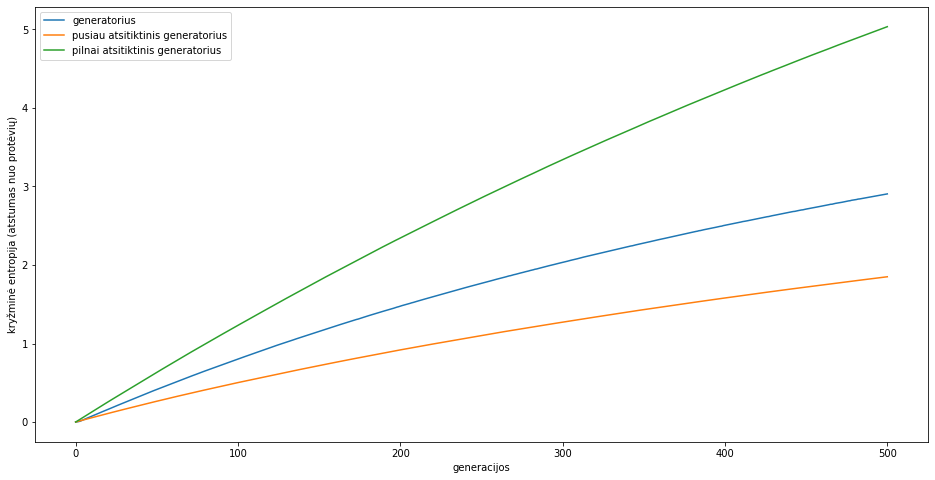

In [111]:
plt.plot(range(len(dists)), dists, label="generatorius")
plt.plot(range(len(rand_dists)), rand_dists, label="pusiau atsitiktinis generatorius")
plt.plot(range(len(true_rand_dists)), true_rand_dists, label="pilnai atsitiktinis generatorius")
plt.xlabel('generacijos')
plt.ylabel('kryžminė entropija (atstumas nuo protėvių)')
plt.legend()
plt.plot()

In [122]:
from scipy.signal import savgol_filter
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

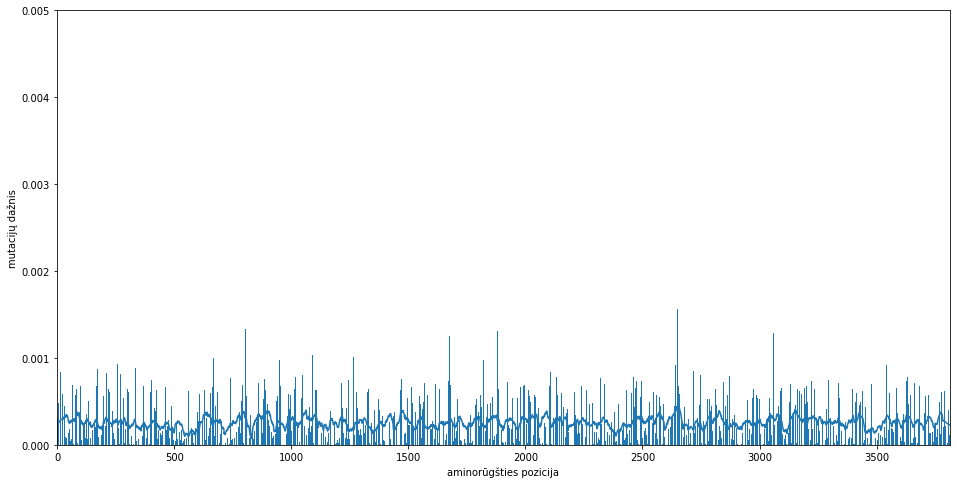

In [149]:
x_range = list(range(len(mut05)))

plt.bar(x_range, mut05 / sum(mut05), label = 'generatorius')
plt.plot(x_range, savgol_filter(mut05 / sum(mut05), 50, 2))
plt.xlim(0, len(mut05))
plt.ylim(0, 0.005)
plt.xlabel('aminorūgšties pozicija')
plt.ylabel('mutacijų dažnis')
plt.show()

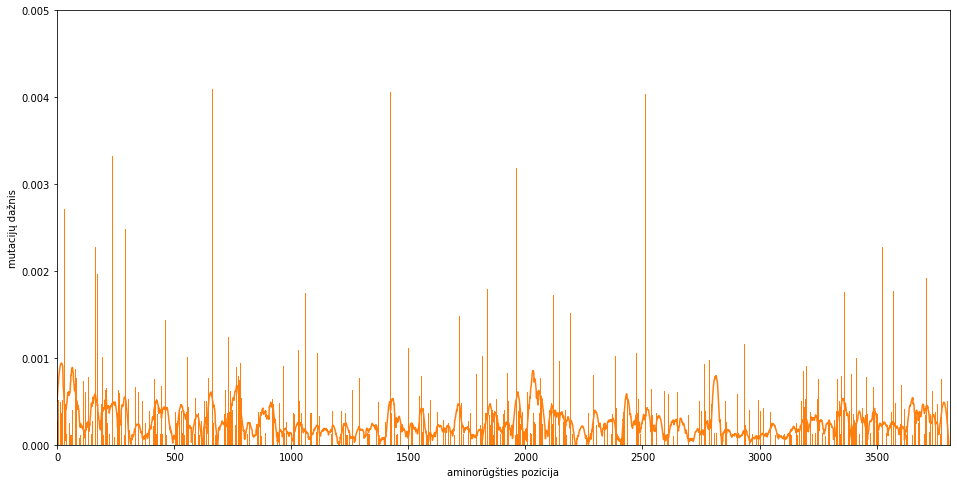

In [147]:
plt.bar(x_range, mut06 / sum(mut06), label = 'pusiau atsitiktinis generatorius', color='C1')
plt.plot(x_range, savgol_filter(mut06 / sum(mut06), 50, 2), color='C1')
plt.xlim(0, len(mut06))
plt.ylim(0, 0.005)
plt.xlabel('aminorūgšties pozicija')
plt.ylabel('mutacijų dažnis')
plt.show()

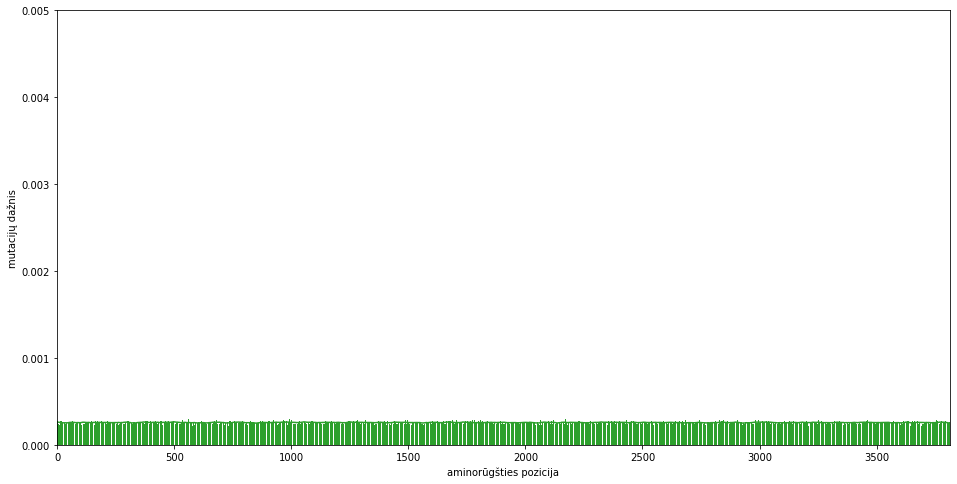

In [148]:
plt.bar(x_range, mut07 / sum(mut07), label = 'pilnai atsitiktinis generatorius', color='C2')
plt.plot(x_range, savgol_filter(mut07 / sum(mut07), 50, 2), color='C2')
plt.xlim(0, len(mut07))
plt.ylim(0, 0.005)
plt.xlabel('aminorūgšties pozicija')
plt.ylabel('mutacijų dažnis')
plt.show()

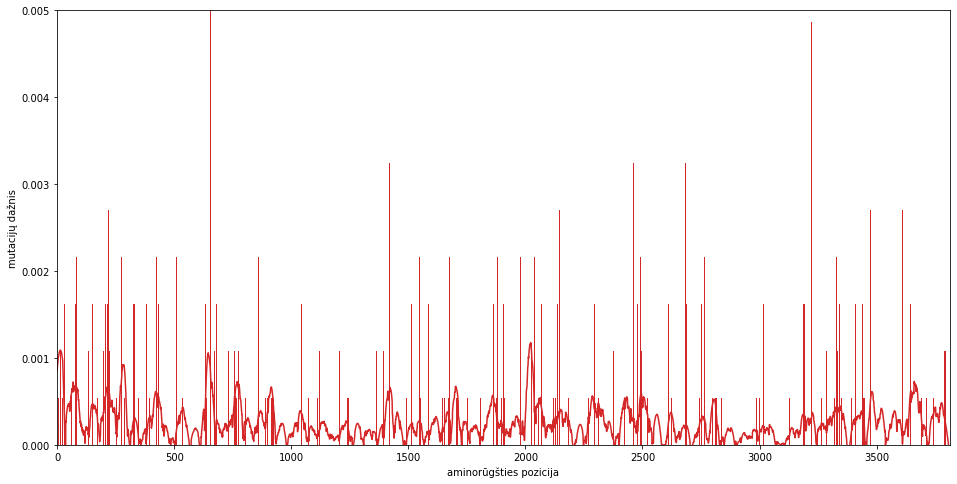

In [152]:
plt.bar(x_range, mut01 / sum(mut01), label = 'stebimos mutacijos', color='C3')
plt.plot(x_range, savgol_filter(mut01 / sum(mut01), 50, 2), color='C3')
plt.xlim(0, len(mut01))
plt.ylim(0, 0.005)
plt.xlabel('aminorūgšties pozicija')
plt.ylabel('mutacijų dažnis')
plt.show()

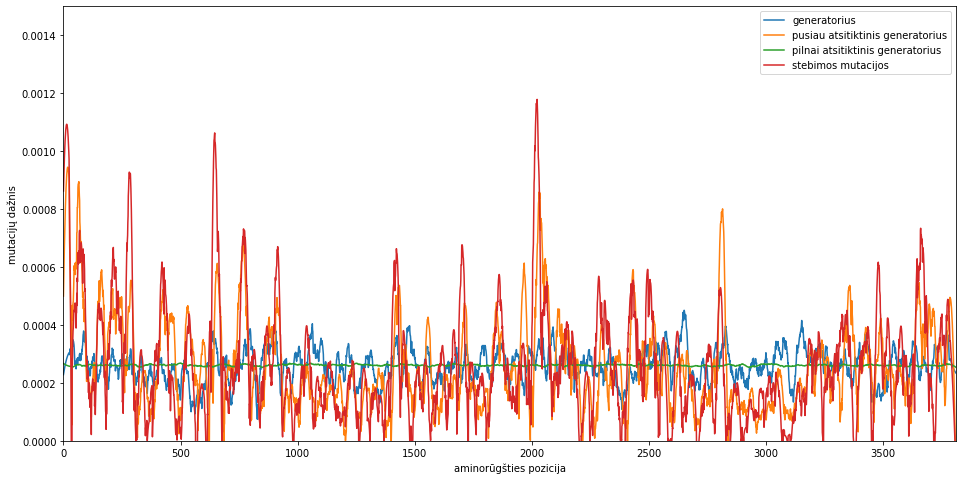

In [156]:
plt.plot(x_range, savgol_filter(mut05 / sum(mut05), 50, 2), label="generatorius")
plt.plot(x_range, savgol_filter(mut06 / sum(mut06), 50, 2), color='C1', label="pusiau atsitiktinis generatorius")
plt.plot(x_range, savgol_filter(mut07 / sum(mut07), 50, 2), label = 'pilnai atsitiktinis generatorius', color='C2')
plt.plot(x_range, savgol_filter(mut01 / sum(mut01), 50, 2), label = 'stebimos mutacijos', color='C3')

plt.xlim(0, len(mut05))
plt.ylim(0, 0.0015)
plt.xlabel('aminorūgšties pozicija')
plt.ylabel('mutacijų dažnis')
plt.legend()
plt.show()

In [19]:
decode_seq(X_data[6:8,:,:])

['ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTG